# Verificação de Aprendizagem - Machine Learning

## Experimentos

### Carregando os Dados

In [1]:
import pandas as pd
import numpy as np
import re

import unicodedata
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.strip().lower()

    # creating a space between a word and the punctuation following it eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping
    # -punctuation
    w = re.sub(r"([?.!,¿#@0-9])", r"", w)

    return w

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [5]:
samples = pd.read_csv('datasets/samples.csv')
X = samples['TEXT'].apply(preprocess_sentence).to_numpy()
y = samples['LANG'].to_numpy()


In [6]:
tfidf_word = TfidfVectorizer(analyzer='word', ngram_range=(2, 3))
X_word_transformed = tfidf_word.fit_transform(X)

tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
X_char_transformed = tfidf_char.fit_transform(X)
X_char_transformed.shape

(2600, 18573)

### Análise Usando TSNE

Em análise preliminar, pode-se ver na figura a disposição dos idiomas em uma projeção 2D. 
Foi utilizado *t-distributed Stochastic Neighbor Embedding* (TSNE) para a redução da dimensionalidade e uma visualização dos dados.
Essa é uma forma bastante popular para visualização de dados em alta-dimensionalidade.
Nessa técnica os objetos são distribuídos de tal forma que pares semelhantes tem uma alta probabilidade na distribuição.
O modelo é treinado para minimizar a divergência em Kullback-Leibler *van2014accelerating*.
Após a redução da dimensionalidade das originais 18095 para apenas duas,  os dados foram postos em uma escala entre 0 e 1.

In [7]:

X_word_embedded = TSNE(n_components=2).fit_transform(X_word_transformed)    
X_char_embedded = TSNE(n_components=2).fit_transform(X_char_transformed)    

X_word_embedded.shape

(2600, 2)

### Normalizando 

Aqui os dados são colocados entre 0 e 1

### Visalização 

Em análise preliminar, pode-se ver na figura a disposição dos idiomas em uma projeção 2D. 
Foi utilizado (TSNE) para a redução da dimensionalidade e uma visualização dos dados.
Essa é uma forma bastante popular para visualização de dados em alta-dimensionalidade.
Nessa técnica os objetos são distribuídos de tal forma que pares semelhantes tem uma alta probabilidade na distribuição.
O modelo é treinado para minimizar a divergência em Kullback-Leibler *van2014accelerating*.
Após a redução da dimensionalidade das originais 18095 para apenas duas,  os dados foram postos em uma escala entre 0 e 1.

In [8]:
word_df = pd.DataFrame(X_word_embedded, columns=['D1', 'D2'])
word_df['Language'] = y
word_df['analyzer'] = 'word'

word_df

,D1,D2,Language,analyzer
0,-18.575867,-1.389621,apalai,word
1,-20.525642,-5.355902,apalai,word
2,-24.916500,-7.510308,apalai,word
3,-5.644816,-3.779052,apalai,word
4,-25.074350,-1.806425,apalai,word
...,...,...,...,...
2595,-13.089823,-33.605980,xavante,word
2596,-1.472815,-2.618402,xavante,word
2597,-21.028271,-35.962406,xavante,word
2598,-18.031231,-33.444801,xavante,word


In [9]:
char_df = pd.DataFrame(X_char_embedded, columns=['D1', 'D2'])
char_df['Language'] = y
char_df['analyzer'] = 'char'
char_df

,D1,D2,Language,analyzer
0,13.983874,-1.852953,apalai,char
1,14.942863,-3.868572,apalai,char
2,13.757576,-6.571644,apalai,char
3,14.512078,-3.737095,apalai,char
4,13.763103,-2.102414,apalai,char
...,...,...,...,...
2595,29.304001,-17.791555,xavante,char
2596,29.069273,-16.369724,xavante,char
2597,30.541073,-18.821054,xavante,char
2598,29.614752,-16.316227,xavante,char


In [10]:
df = pd.concat([word_df, char_df])
df

,D1,D2,Language,analyzer
0,-18.575867,-1.389621,apalai,word
1,-20.525642,-5.355902,apalai,word
2,-24.916500,-7.510308,apalai,word
3,-5.644816,-3.779052,apalai,word
4,-25.074350,-1.806425,apalai,word
...,...,...,...,...
2595,29.304001,-17.791555,xavante,char
2596,29.069273,-16.369724,xavante,char
2597,30.541073,-18.821054,xavante,char
2598,29.614752,-16.316227,xavante,char


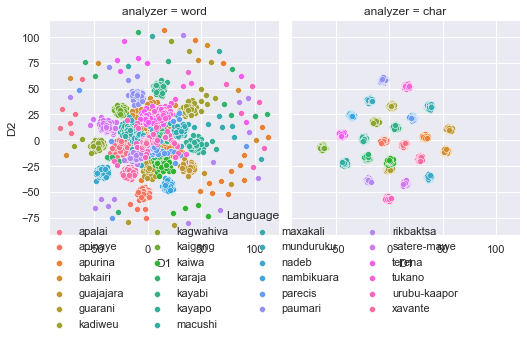

In [11]:
import matplotlib.pyplot as plt

import seaborn as sns


sns.set_theme(style="darkgrid")

g = sns.FacetGrid(df, col="analyzer", hue="Language", height=4,
                       legend_out=True)
g.map(sns.scatterplot, "D1", "D2")
g.add_legend(loc='lower center',
             bbox_to_anchor=(0.3, -0.2),
             
          ncol=4)

plt.savefig('tsne_vis.pdf')

### Preprocessando e Extraindo Features

In [12]:
CLFS_LIST = [('Word TFIDF+LinearSVC',  Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(2, 3))), ('svc', LinearSVC())])),
             ('Word TFIDF+MultinomialNB',Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(2, 3))), ('multinomialnb', MultinomialNB())])),
             ('Word TFIDF+LogisticRegression',Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(2, 3))), ('multinomialnb', LogisticRegression())])),
             ('Char TFIDF+LinearSVC',  Pipeline([('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2, 3))), ('svc', LinearSVC())])),
             ('Char TFIDF+MultinomialNB',Pipeline([('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2, 3))), ('multinomialnb', MultinomialNB())])),
             ('Char TFIDF+LogisticRegression',Pipeline([('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2, 3))), ('multinomialnb', LogisticRegression())]))]


In [13]:
samples.sample(frac=0.1).value_counts('LANG')

LANG
munduruku       15
nambikuara      14
satere-mawe     13
apinaye         12
urubu-kaapor    12
terena          12
guarani         12
kaigang         12
maxakali        12
kayapo          12
apalai          11
tukano          11
parecis         10
xavante         10
kagwahiva       10
karaja           9
paumari          9
rikbaktsa        9
guajajara        9
bakairi          8
apurina          8
kayabi           7
macushi          7
kaiwa            6
kadiweu          6
nadeb            4
dtype: int64

In [14]:
from sklearn.model_selection import StratifiedKFold
exp_timeline = pd.DataFrame({'accuracy': [],'classifier_name':[]})
from tqdm import tqdm
for i in range(2,11):
  for clf_name,estimator in tqdm(CLFS_LIST):
    skf = StratifiedKFold(n_splits=10)
    small_sample = samples.sample(frac=i/10)
    X_sample = small_sample['TEXT'].apply(preprocess_sentence).to_numpy()
    y_sample = small_sample['LANG'].to_numpy()

    scores = cross_validate(estimator, X_sample, y_sample, cv=skf,
                              scoring=('accuracy', 'f1_macro'), return_train_score=False)
    exp_df = pd.DataFrame({
        'exp_id':i-1,
        'accuracy':scores['test_accuracy'],
        'f1_macro':scores['test_f1_macro'],
        'classifier_name':[clf_name for _ in range(10)],
        
        'dataset_name':[str(i*10)+'%' for _ in range(10)]
    })

    exp_timeline = exp_timeline.append(exp_df)

exp_timeline

100%|██████████| 6/6 [06:37<00:00, 66.18s/it]


,accuracy,classifier_name,exp_id,f1_macro,dataset_name
0,0.846154,Word TFIDF+LinearSVC,1.0,0.824176,20%
1,0.846154,Word TFIDF+LinearSVC,1.0,0.811355,20%
2,0.846154,Word TFIDF+LinearSVC,1.0,0.842125,20%
3,0.923077,Word TFIDF+LinearSVC,1.0,0.933333,20%
4,0.942308,Word TFIDF+LinearSVC,1.0,0.949359,20%
...,...,...,...,...,...
5,1.000000,Char TFIDF+LogisticRegression,9.0,1.000000,100%
6,1.000000,Char TFIDF+LogisticRegression,9.0,1.000000,100%
7,1.000000,Char TFIDF+LogisticRegression,9.0,1.000000,100%
8,1.000000,Char TFIDF+LogisticRegression,9.0,1.000000,100%


In [15]:
exp_timeline['dataset_name'].value_counts()

20%     60
30%     60
40%     60
50%     60
60%     60
70%     60
80%     60
90%     60
100%    60
Name: dataset_name, dtype: int64

In [31]:
time_analyses = exp_timeline.groupby(['dataset_name', 'classifier_name', 'exp_id']).agg({'accuracy': ['mean', 'std'], 'f1_macro': ['mean', 'std']})

In [43]:
time_analyses.round(2).to_latex('agg.txt')

In [36]:
acc_time_analyses = time_analyses['accuracy'].reset_index(level=['dataset_name', 'classifier_name', 'exp_id'])
acc_time_analyses.sort_values(by='exp_id', inplace=True)

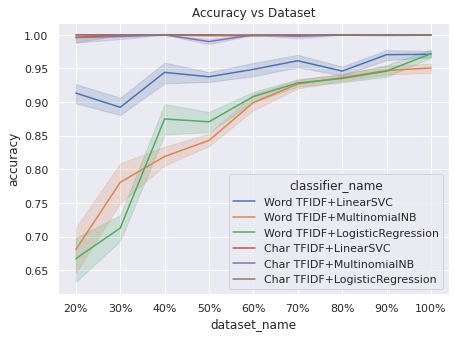

In [42]:
import seaborn as sns
sns.set(rc={'figure.figsize':(7.,5)})
g = sns.lineplot(data=exp_timeline,x='dataset_name', y='accuracy', hue='classifier_name')

g.set_title('Accuracy vs Dataset')
plt.savefig('acc_timeline_graph.pdf')

In [21]:
g.get_xticklabels()

<a list of 9 Text major ticklabel objects>

In [22]:
skf = StratifiedKFold(n_splits=10)
#cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=42)

def run_experiment(X_, y_):
 
  exp_results = pd.DataFrame({'accuracy': [],'classifier_name':[],'fit_time':[]})
  
  
  for clf in CLFS_LIST:
    step = 1
    clf_name, estimator = clf
    print(f"Treinando {clf_name}...")
    scores = cross_validate(estimator, X_, y_, cv=skf,
                            scoring=('accuracy', 'f1_macro'),
                            return_train_score=False)
    exp_df = pd.DataFrame({
        'accuracy':scores['test_accuracy'],
        'f1_macro':scores['test_f1_macro'],
        'classifier_name':[clf_name for _ in range(10)],
        
        'dataset_name':['dataset'+str(i) for i in range(step, step+10)]
    })
    exp_results = exp_results.append(exp_df)
 
  return exp_results.fillna(0)

In [23]:
!mkdir results/

In [24]:
result_df = run_experiment(X, y)
result_df.to_csv('results/result.csv')

Treinando Word TFIDF+LinearSVC...
Treinando Word TFIDF+MultinomialNB...
Treinando Word TFIDF+LogisticRegression...
Treinando Char TFIDF+LinearSVC...
Treinando Char TFIDF+MultinomialNB...
Treinando Char TFIDF+LogisticRegression...


In [25]:
groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'],'f1_macro':['mean', 'median', 'std']}).round(3)

open('results/result.txt', 'w', encoding='utf-8').write(summary.to_latex())
summary

accuracy               f1_macro              
                                  mean median    std     mean median    std
classifier_name                                                            
Char TFIDF+LinearSVC             1.000  1.000  0.000    1.000  1.000  0.000
Char TFIDF+LogisticRegression    1.000  1.000  0.000    1.000  1.000  0.000
Char TFIDF+MultinomialNB         1.000  1.000  0.000    1.000  1.000  0.000
Word TFIDF+LinearSVC             0.972  0.979  0.018    0.975  0.980  0.015
Word TFIDF+LogisticRegression    0.972  0.977  0.017    0.974  0.978  0.015
Word TFIDF+MultinomialNB         0.950  0.954  0.018    0.953  0.956  0.015

### Experimentos Usando TSNE

In [26]:
!git clone https://github.com/Tiagoblima/cd-diagram.git

Cloning into 'cd-diagram'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 42 (delta 4), reused 13 (delta 3), pack-reused 28
Unpacking objects: 100% (42/42), done.


In [27]:
!mkdir images

In [28]:
from IPython.display import Image, display

!python cd-diagram/main.py --results results/result.csv --metric accuracy --img images/cd-accuracy.pdf
display(Image('images/cd-accuracy.png'))

['Word TFIDF+LinearSVC' 'Word TFIDF+MultinomialNB'
 'Word TFIDF+LogisticRegression' 'Char TFIDF+LinearSVC'
 'Char TFIDF+MultinomialNB' 'Char TFIDF+LogisticRegression']
Traceback (most recent call last):
  File "cd-diagram/main.py", line 403, in <module>
    main(sys.argv[1:])
  File "cd-diagram/main.py", line 399, in main
    draw_cd_diagram(df_perf=df_perf, title=args.metric, labels=True, filename=args.img)
  File "cd-diagram/main.py", line 287, in draw_cd_diagram
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha, metric=title)
  File "cd-diagram/main.py", line 347, in wilcoxon_holm
    p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
  File "/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py", line 2870, in wilcoxon
    raise ValueError("zero_method 'wilcox' and 'pratt' do not work if "
ValueError: zero_method 'wilcox' and 'pratt' do not work if the x - y is zero for all elements.


In [29]:
from IPython.display import Image, display

!python cd-diagram/main.py --results results/result_char.csv --metric f1_macro --img images/cd-f1_macro.pdf
display(Image('images/cd-f1_macro.png'))

Traceback (most recent call last):
  File "cd-diagram/main.py", line 403, in <module>
    main(sys.argv[1:])
  File "cd-diagram/main.py", line 397, in main
    df_perf = pd.read_csv(args.results, index_col=False)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 688, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 454, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 948, in __init__
    self._make_engine(self.engine)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 1180, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 2010, in __init__
    self._reader = parsers.TextReader(src, **kwds)
  File "pandas/_libs/parsers.pyx", line 382, in pandas._libs.parsers.TextReader.__cinit__
